In [71]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")



In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:

# Define dataset path
dataset_path = "/content/drive/MyDrive/images"

# Define labels
fruit_labels_dict = {
    'mango fruit': 0,
    'kiwi fruit': 1,
    'apple fruit': 2,
    'banana fruit': 3,
    'cherry fruit': 4,
    'chickoo fruit': 5,
    'grapes fruit': 6,
    'orange fruit': 7,
    'strawberry fruit': 8
}

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Load images from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    class_names=list(fruit_labels_dict.keys()),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)


Found 360 files belonging to 9 classes.


In [74]:


# Normalize images (scale pixel values to [0,1])
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

dataset = dataset.map(normalize_img)


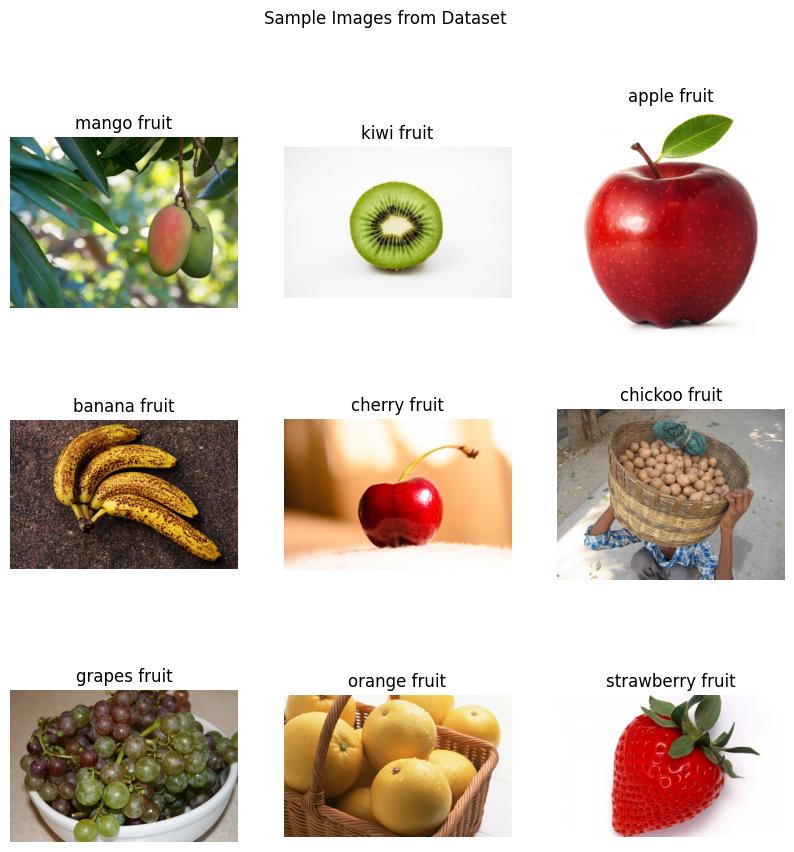

In [75]:
# -------------------- SAMPLE IMAGES --------------------
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for idx, fruit_class in enumerate(fruit_labels_dict.keys()):
    fruit_folder = os.path.join(dataset_path, fruit_class)
    image_name = os.listdir(fruit_folder)[0]  # Pick first image
    img = cv2.imread(os.path.join(fruit_folder, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    axes[idx].imshow(img)
    axes[idx].set_title(fruit_class)
    axes[idx].axis('off')

plt.suptitle("Sample Images from Dataset")
plt.show()

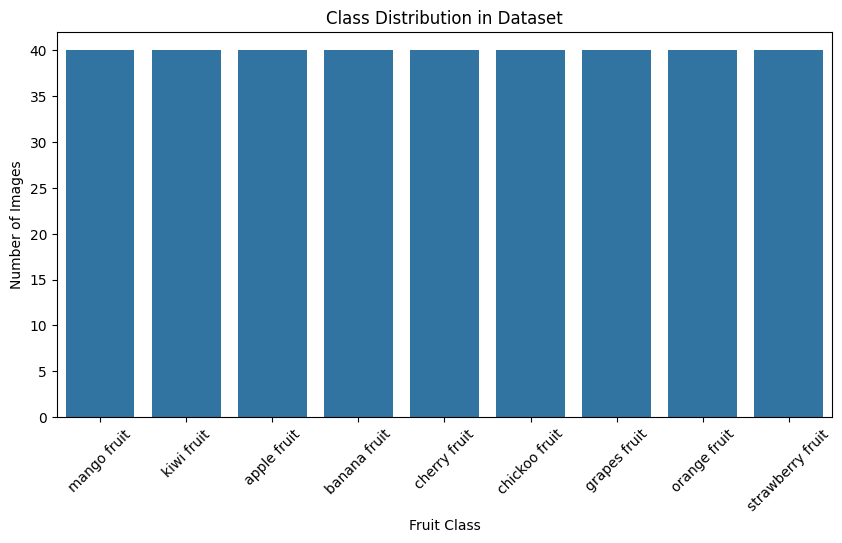

In [76]:
# -------------------- CLASS DISTRIBUTION PLOT --------------------
class_counts = {label: len(os.listdir(os.path.join(dataset_path, label))) for label in fruit_labels_dict.keys()}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.xlabel("Fruit Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

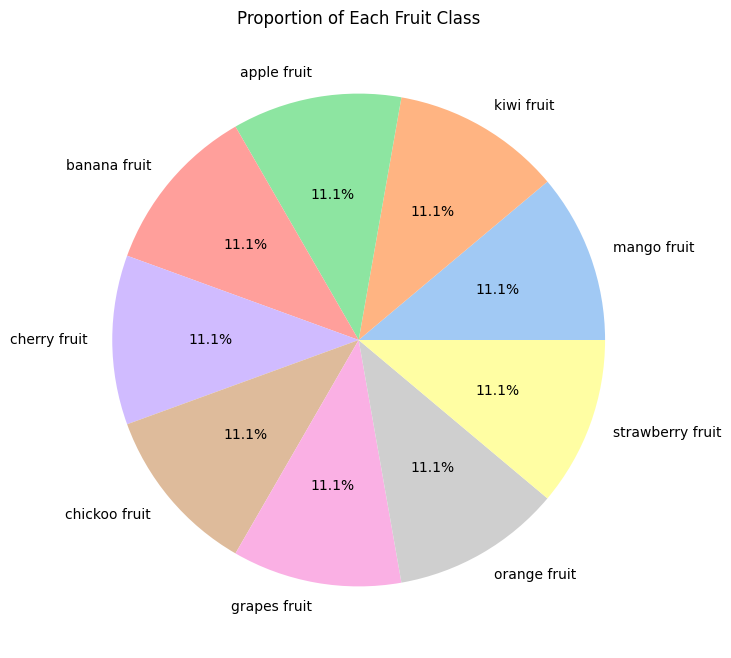

In [77]:
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Proportion of Each Fruit Class")
plt.show()


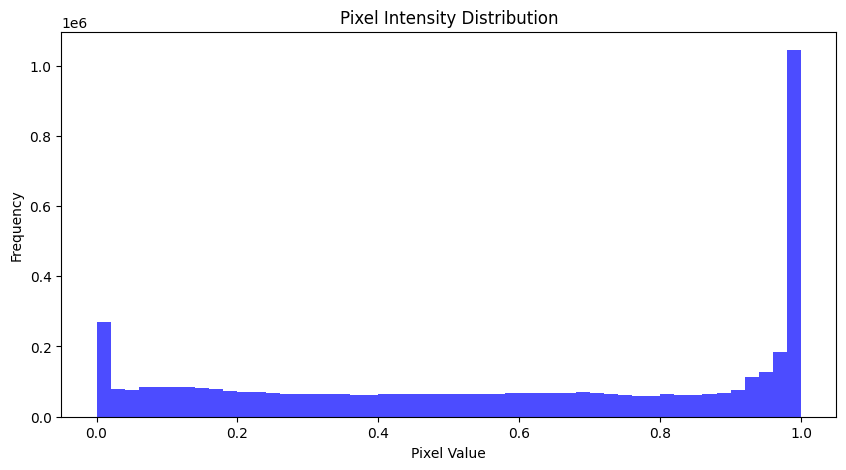

In [78]:

images, labels = next(iter(dataset))

plt.figure(figsize=(10, 5))
plt.hist(images.numpy().ravel(), bins=50, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()



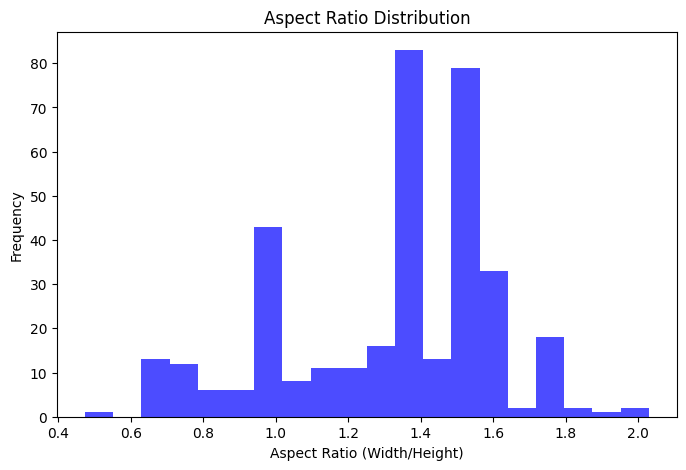

In [79]:
# Get image dimensions
widths, heights = [], []
for label in fruit_labels_dict.keys():
    label_path = os.path.join(dataset_path, label)
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

# Plot aspect ratio distribution
aspect_ratios = np.array(widths) / np.array(heights)
plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=20, color='blue', alpha=0.7)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.show()


In [80]:
# Split dataset into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

# Prefetch to improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [81]:

# -------------------- BUILDING CNN MODEL --------------------

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(fruit_labels_dict), activation='softmax')  # Output layer
])

In [82]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,177,801 (42.64 MB)

 Trainable params: 11,177,801 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [84]:
# -------------------- TRAIN & EVALUATE MODEL --------------------

# Train the model
history = model.fit(train_ds, validation_data=test_ds, epochs=14)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.1145 - loss: 2.8877 - val_accuracy: 0.1389 - val_loss: 2.1851
Epoch 2/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.1594 - loss: 2.1825 - val_accuracy: 0.1944 - val_loss: 2.0510
Epoch 3/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.1637 - loss: 2.0990 - val_accuracy: 0.1667 - val_loss: 1.9299
Epoch 4/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.2582 - loss: 1.9474 - val_accuracy: 0.3889 - val_loss: 1.8617
Epoch 5/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.2219 - loss: 1.9151 - val_accuracy: 0.3889 - val_loss: 1.6229
Epoch 6/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.3278 - loss: 1.7566 - val_accuracy: 0.4583 - val_loss: 1.5996
Epoch 7/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.4157 - loss: 1.6364 - val_accuracy: 0.4444 - val_loss: 1.4952
Epoch 8/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.4613 - loss: 1.5037 - val_accuracy: 0.6806 - val_loss: 1.2240
Epoch 9/

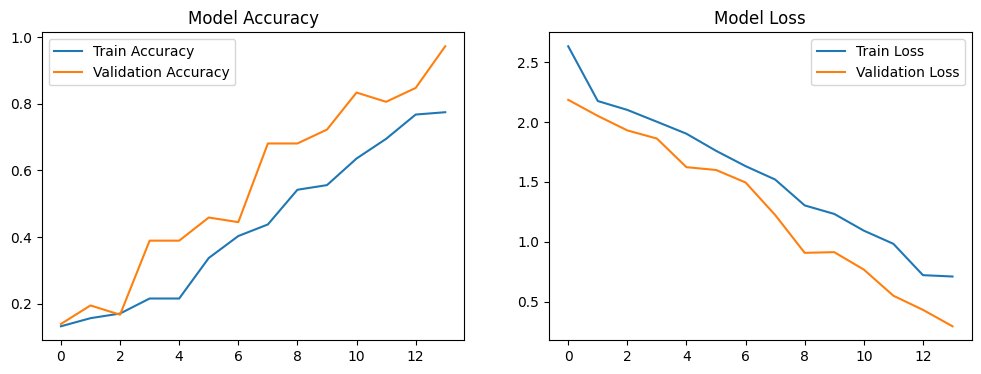

In [85]:

# -------------------- VISUALIZATION --------------------

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")

plt.show()

In [86]:

# Function to extract images and labels from TensorFlow dataset
def dataset_to_numpy(ds):
    images, labels = [], []
    for img_batch, label_batch in ds:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())

    return np.concatenate(images), np.concatenate(labels)

# Convert test dataset
X_test, y_test = dataset_to_numpy(test_ds)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step


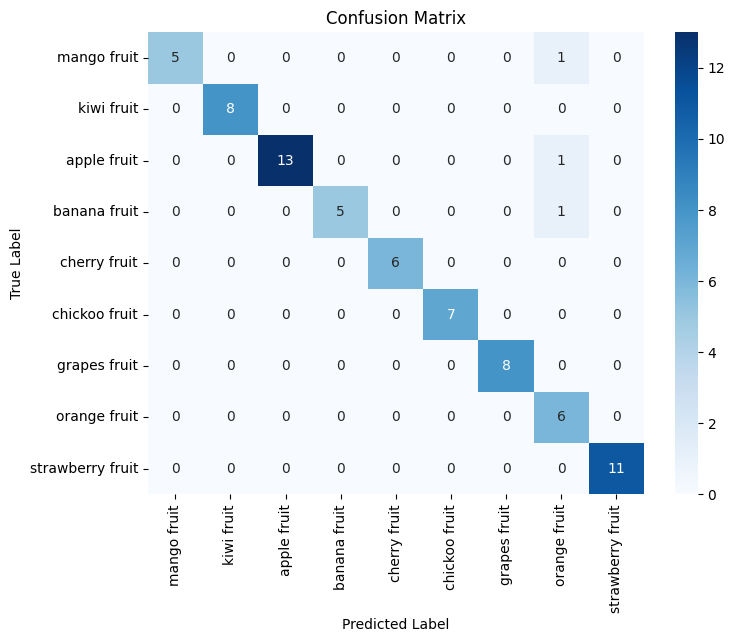

In [87]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)



conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d',
            xticklabels=fruit_labels_dict.keys(),
            yticklabels=fruit_labels_dict.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
